In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cat

from sklearn import linear_model as lm

from sklearn.preprocessing import SplineTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error


# Séries Temporais
No contexto de análise e ciência de dados, séries temporais são dados observados de forma sequencial, em intervalos regulares ou irregulares. Muitas vezes esses dados são resultado de agregações feitas por um campo de data: podemos construir a série temporal do número de itens vendidos pelo Olist por dia, ou então o número de ataques de tubarão for mês.

# Dataset

Vamos continuar a análise do conjunto de dados de cancelamentos de reservas em 2 hotéis europeus. No entanto, enquanto no case de sábado passado fizemos uma análise baseada no dado transacional (cada individuo de nossa tabela era uma reserva) hoje agregaremos este dado e analisaremos o resultado agregado diário para um dos hotéis.

Primeiro vamos carregar o conjunto de dados de hotéis e transformar a informação de data em campos datetime. Isso nos permitirá calcular a data na qual a reserva foi feita.

In [3]:
tb_hotel = pd.read_csv("data/tb_hotel_bookings_full.csv")

tb_hotel["arrival_dt"] = pd.to_datetime(tb_hotel["arrival_date"])
tb_hotel["update_dt"] = pd.to_datetime(tb_hotel["reservation_status_date"])
tb_hotel.head()

,Unnamed: 0,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,id_booking,arrival_dt,update_dt
0,0,Resort Hotel,0,342,0,0,2,0.0,0,BB,...,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,0,2015-07-01,2015-07-01
1,1,Resort Hotel,0,737,0,0,2,0.0,0,BB,...,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,1,2015-07-01,2015-07-01
2,2,Resort Hotel,0,7,0,1,1,0.0,0,BB,...,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2,2015-07-01,2015-07-02
3,3,Resort Hotel,0,13,0,1,1,0.0,0,BB,...,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,3,2015-07-01,2015-07-02
4,4,Resort Hotel,0,14,0,2,2,0.0,0,BB,...,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,4,2015-07-01,2015-07-03


In [4]:
tb_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unnamed: 0                      119390 non-null  int64         
 1   hotel                           119390 non-null  object        
 2   is_canceled                     119390 non-null  int64         
 3   lead_time                       119390 non-null  int64         
 4   stays_in_weekend_nights         119390 non-null  int64         
 5   stays_in_week_nights            119390 non-null  int64         
 6   adults                          119390 non-null  int64         
 7   children                        119386 non-null  float64       
 8   babies                          119390 non-null  int64         
 9   meal                            119390 non-null  object        
 10  country                         118902 non-null  object 

In [10]:
pd.to_timedelta(tb_hotel["lead_time"], unit="d")

0        342 days
1        737 days
2          7 days
3         13 days
4         14 days
           ...   
119385    23 days
119386   102 days
119387    34 days
119388   109 days
119389   205 days
Name: lead_time, Length: 119390, dtype: timedelta64[ns]

In [11]:
tb_hotel["reserva_dt"] = tb_hotel["arrival_dt"] - pd.to_timedelta(tb_hotel["lead_time"], unit="d")

In [12]:
tb_hotel["reserva_dt"]

0        2014-07-24
1        2013-06-24
2        2015-06-24
3        2015-06-18
4        2015-06-17
            ...    
119385   2017-08-07
119386   2017-05-21
119387   2017-07-28
119388   2017-05-14
119389   2017-02-05
Name: reserva_dt, Length: 119390, dtype: datetime64[ns]

Para construir a série temporal de cancelamentos e reservas precisamos decidir por qual campo de data agregaremos nossos dados:

1. **Data de Chegada**
1. **Data da Reserva**
1. **Data da Última Atualização da Reserva**

Essa opção é algo comum quando construímos séries temporais (no âmbito de produtos por exemplo podemos ver as datas de compra, de faturamento e de entrega por exemplo). Por enquanto limitaremos a análise à **data de chegada**.

In [85]:
tb_resort = tb_hotel[tb_hotel["hotel"] == "City Hotel"]

In [86]:
tb_resort_ts = (
    tb_resort.groupby("arrival_dt")
    .agg(
        num_reservas=pd.NamedAgg("id_booking", "count"),
        num_canceladas=pd.NamedAgg("is_canceled", "sum"),
    )
    .reset_index()
)
tb_resort_ts.head()


,arrival_dt,num_reservas,num_canceladas
0,2015-07-01,79,14
1,2015-07-02,49,48
2,2015-07-03,16,6
3,2015-07-04,38,29
4,2015-07-05,8,8


In [87]:
tb_resort_ts.shape

(793, 3)

In [88]:
tb_resort_ts["per_canceladas"] = (
    tb_resort_ts["num_canceladas"] / tb_resort_ts["num_reservas"]
)

A forma mais comum de visualizar dados de série temporal é através de **lineplots** onde o tempo é colocado no eixo X e as variáveis a serem analisadas no eixo Y.

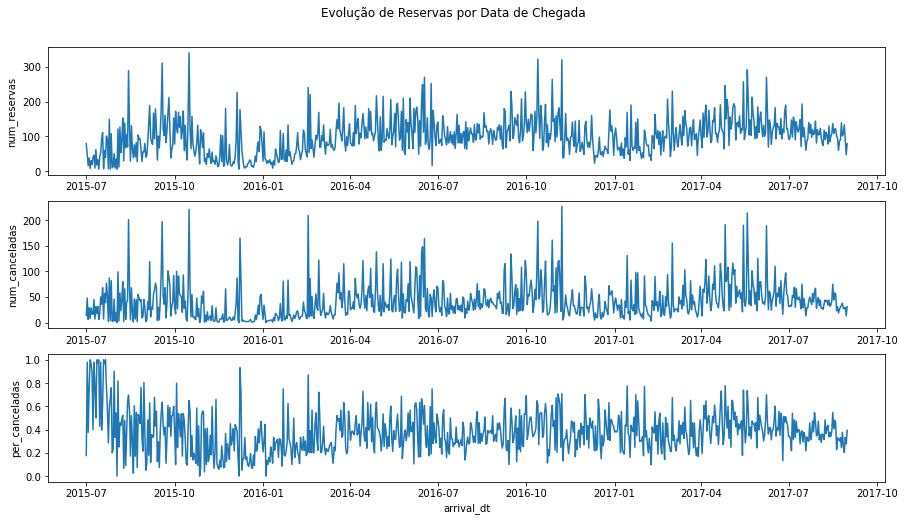

In [89]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_reservas", ax=ax[0])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_canceladas", ax=ax[1])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas", ax=ax[2])
ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95);


In [107]:
tb_resort_ts[['d_num_reservas', 'num_reservas']]

,d_num_reservas,num_reservas
0,NaN,79
1,-30.0,49
2,-33.0,16
3,22.0,38
4,-30.0,8
...,...,...
788,6.0,107
789,26.0,133
790,-43.0,90
791,-43.0,47


<AxesSubplot:xlabel='arrival_dt', ylabel='d_num_reservas'>

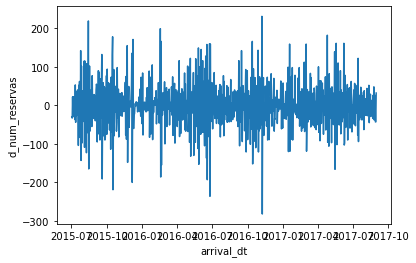

In [106]:
tb_resort_ts['d_num_reservas'] = tb_resort_ts['num_reservas'].diff()
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="d_num_reservas")



## Train & Test para séries temporais
A nossa estratégia tradicional para divisão de um dataset em train e test não funciona em séries temporais: como elas são definidas pela sequencialidade das observações, remover pontos aleatórios de dentro da série seria estranho... A forma mais simples e tradicional de se fazer essa divisão é selecionando pontos no fim da série como nosso conjunto teste. No exemplo acima optei por formar o conjunto de train a partir dos dois primeiros anos continuos que temos na série (veremos porque quando olharmos componentes sazonais).

In [19]:
tb_resort_ts["arrival_dt"].describe()


/var/folders/c2/4vv1dtt97gl9bn1lvw8rf0k40000gn/T/ipykernel_24691/944963118.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tb_resort_ts["arrival_dt"].describe()


count                     793
unique                    793
top       2015-07-01 00:00:00
freq                        1
first     2015-07-01 00:00:00
last      2017-08-31 00:00:00
Name: arrival_dt, dtype: object

Ao invés de realizar a transformação agora, vamos definir uma função que realiza essa divisão para nós. Dessa forma não precisamos replicar nosso feature engineering em 2 datasets o tempo todo.

In [20]:
def split_hotel_ts(hotel_data, break_date):
    train_data = hotel_data[hotel_data["arrival_dt"] < break_date].copy()
    test_data = hotel_data[hotel_data["arrival_dt"] >= break_date].copy()
    return train_data, test_data


# Decomposição TCSI

A forma mais tradicional de se analisar um série temporal é através da decomposição TCSI:

1. **T - Componente de Tendência (Trend):** representação da evolução a longo prazo da série (*a taxa de cancelamento está crescendo ou caindo?*)
1. **C - Componente Ciclico (Cyclic)** representação da evolução ciclica não periódicas (*tivemos momentos com mais (ou menos) cancelamentos de forma estrutural?*)
1. **S - Componente Sazonal (Seasonal)** representação da peridiocidade sazonal (ciclo regular) (*temos mais cancelamento para reservas em junho? ou para reservas de segunda-feira? ou da última semana do mês?*)
1. **I - Componente de Ruído (Irregular/Noise)** o que não é representado pelos três componentes acima.

## Componente de Tendência (Trend)

In [21]:
tb_resort_ts["t_dias"] = (
    tb_resort_ts["arrival_dt"] - min(tb_resort_ts["arrival_dt"])
).dt.total_seconds() / (24 * 60 * 60)
tb_resort_ts.head()

,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias
0,2015-07-01,43,5,0.116279,0.0
1,2015-07-02,44,9,0.204545,1.0
2,2015-07-03,40,13,0.325000,2.0
3,2015-07-04,50,14,0.280000,3.0
4,2015-07-05,45,8,0.177778,4.0


In [ ]:
import catboost

### Estimativa de tendência linear

In [34]:
train_data, test_data = split_hotel_ts(tb_resort_ts, "2017-08-01")

(31, 5)

In [35]:
trend_fit = lm.LinearRegression()

trend_fit.fit(train_data[["t_dias"]], train_data["per_canceladas"])


LinearRegression()

In [36]:
trend_fit.coef_

array([0.00013428])

In [37]:
tb_resort_ts["pred_trend_linear"] = trend_fit.predict(tb_resort_ts[["t_dias"]])


Text(0.5, 0.95, 'Evolução de Reservas por Data de Chegada')

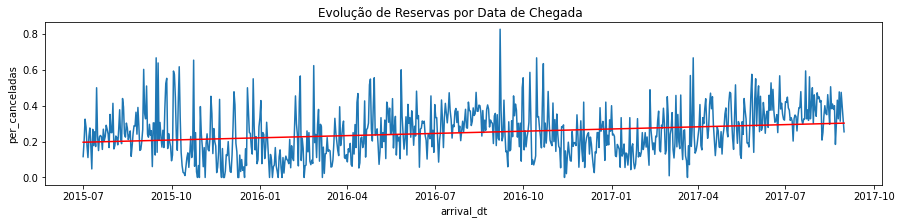

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="pred_trend_linear", color="red")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95)


In [40]:
tb_hotel.groupby('hotel')['is_canceled'].mean()

hotel
City Hotel      0.417270
Resort Hotel    0.277634
Name: is_canceled, dtype: float64

## Componente Cíclico (Cycle)

Como os ciclos representam variações não-periódicas é dificil separa-los da avaliação de tendência (principalmente em séries curtas). Vamos utilizar três técnicas para estimar variações em relação a tendência.

### Tendência Polinomial

In [41]:
from sklearn.preprocessing import PolynomialFeatures


In [42]:
poly_trans = PolynomialFeatures(degree=2)
poly_trans.fit(train_data[["t_dias"]])


PolynomialFeatures()

In [43]:
poly_trans.n_output_features_


3

In [ ]:
tb_resort_ts

In [44]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
pd.DataFrame(
            poly_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=poly_names,
        )

,P0,P1,P2
0,1.0,0.0,0.0
1,1.0,1.0,1.0
2,1.0,2.0,4.0
3,1.0,3.0,9.0
4,1.0,4.0,16.0
...,...,...,...
788,1.0,788.0,620944.0
789,1.0,789.0,622521.0
790,1.0,790.0,624100.0
791,1.0,791.0,625681.0


In [46]:
poly_trans.transform(tb_resort_ts[["t_dias"]])

array([[1.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.00000e+00, 1.00000e+00, 1.00000e+00],
       [1.00000e+00, 2.00000e+00, 4.00000e+00],
       ...,
       [1.00000e+00, 7.90000e+02, 6.24100e+05],
       [1.00000e+00, 7.91000e+02, 6.25681e+05],
       [1.00000e+00, 7.92000e+02, 6.27264e+05]])

In [47]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
tb_resort_ts_p = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            poly_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=poly_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_p.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,P0,P1,P2
0,2015-07-01,43,5,0.116279,0.0,0.196375,1.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,1.0,1.0,1.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,1.0,2.0,4.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,1.0,3.0,9.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,1.0,4.0,16.0


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau 2')

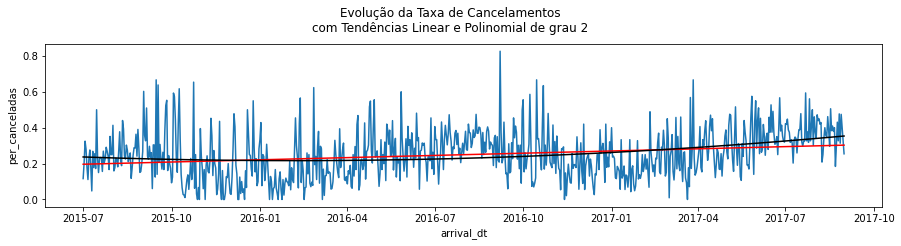

In [51]:
train_data, test_data = split_hotel_ts(tb_resort_ts_p, "2017-08-01")

poly_trend_fit = lm.LinearRegression()
poly_trend_fit.fit(train_data[poly_names], train_data["per_canceladas"])



tb_resort_ts_p["pred_trend_poly"] = poly_trend_fit.predict(tb_resort_ts_p[poly_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_poly", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


In [52]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_poly"] = poly_trend_fit.predict(test_data[poly_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_poly = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_poly"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_poly, 2)}")


Trend Lin.: 0.11
Trend Poly.: 0.08


### B-Splines

In [56]:
spl_trans = SplineTransformer(n_knots=24, extrapolation="constant")
spl_trans.fit(train_data[["t_dias"]])

SplineTransformer(n_knots=24)

In [57]:
spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
spl_names

['S0',
 'S1',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8',
 'S9',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14',
 'S15',
 'S16',
 'S17',
 'S18',
 'S19',
 'S20',
 'S21',
 'S22',
 'S23',
 'S24',
 'S25']

In [58]:
spl_trans.transform(tb_resort_ts[["t_dias"]])

array([[0.16666667, 0.66666667, 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.1520071 , 0.66576702, 0.18222128, ..., 0.        , 0.        ,
        0.        ],
       [0.13823337, 0.66312328, 0.19860653, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.66666667,
        0.16666667],
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.66666667,
        0.16666667],
       [0.        , 0.        , 0.        , ..., 0.16666667, 0.66666667,
        0.16666667]])

In [59]:
pd.DataFrame(spl_trans.transform(tb_resort_ts[["t_dias"]]), columns=spl_names)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25
0,0.166667,0.666667,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.152007,0.665767,0.182221,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.138233,0.663123,0.198607,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.125318,0.658818,0.215740,0.000124,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.113233,0.652935,0.233538,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
789,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
790,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667
791,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.666667,0.166667


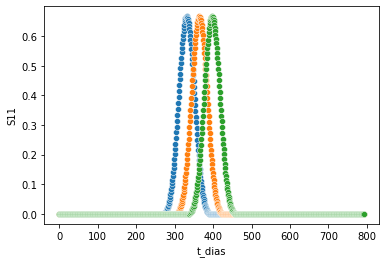

In [62]:
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            spl_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_b.head()
sns.scatterplot(data = tb_resort_ts_b, x = 't_dias', y = 'S11');
sns.scatterplot(data = tb_resort_ts_b, x = 't_dias', y = 'S12');
sns.scatterplot(data = tb_resort_ts_b, x = 't_dias', y = 'S13');


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines')

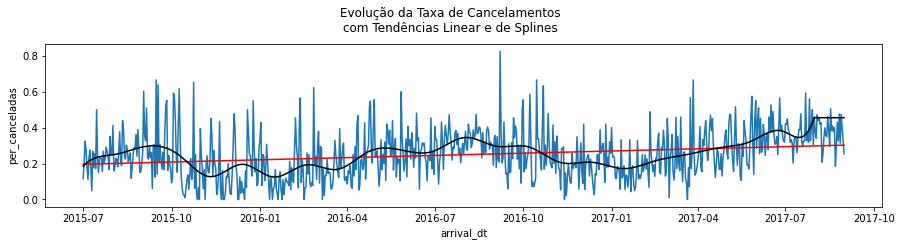

In [63]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b, "2017-08-01")

spline_fit = lm.LinearRegression()
spline_fit.fit(train_data[spl_names], train_data["per_canceladas"])

tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
)


In [64]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline: {round(rmse_spl, 2)}")


Trend Lin.: 0.11
Trend Spline: 0.11


O que podemos melhorar aqui?

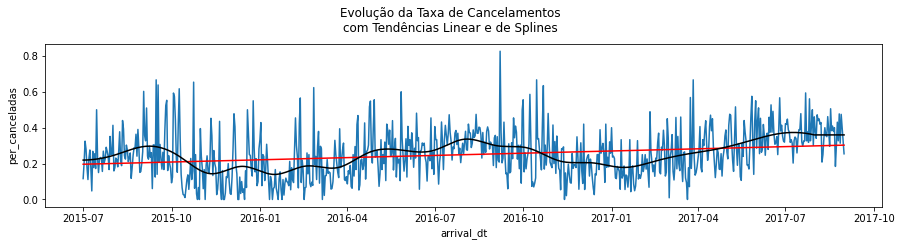

In [65]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b, "2017-08-01")

spline_fit = lm.RidgeCV(cv = 5)
spline_fit.fit(train_data[spl_names], train_data["per_canceladas"])

tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
);


In [66]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")


Trend Lin.: 0.11
Trend Spline.: 0.08


In [91]:
tb_resort_ts_b.columns

Index(['arrival_dt', 'num_reservas', 'num_canceladas', 'per_canceladas',
       't_dias', 'pred_trend_linear', 'S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6',
       'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16',
       'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25',
       'pred_spline', 'mes', 'dia_semana'],
      dtype='object')

In [92]:
tb_resort_ts_b['ruido'] = tb_resort_ts_b['per_canceladas'] - tb_resort_ts_b['pred_spline']

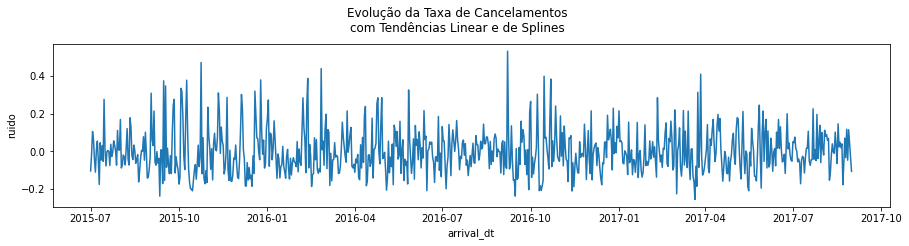

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="ruido")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
);

<AxesSubplot:xlabel='ruido', ylabel='Count'>

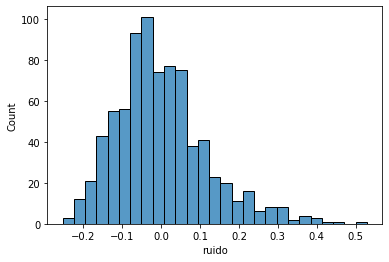

In [94]:
sns.histplot(data = tb_resort_ts_b, x = 'ruido')

## Componente Sazonal

### Variáveis Sazonais Dummy

In [69]:
tb_resort_ts_b["mes"] = tb_resort_ts_b["arrival_dt"].dt.month.astype(str)
tb_resort_ts_b["dia_semana"] = tb_resort_ts_b["arrival_dt"].dt.weekday.astype(str)


In [70]:
tb_resort_ts_b[["mes", "dia_semana"]]


,mes,dia_semana
0,7,2
1,7,3
2,7,4
3,7,5
4,7,6
...,...,...
788,8,6
789,8,0
790,8,1
791,8,2


In [71]:
ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])


OneHotEncoder(drop='first', sparse=False)

In [73]:
pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=ohe_fit.get_feature_names_out(),
        )

,mes_10,mes_11,mes_12,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [74]:
ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])

tb_resort_ts_d = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=ohe_fit.get_feature_names_out(),
        ),
    ],
    axis=1,
)


In [75]:
tb_resort_ts_d.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,S0,S1,S2,S3,...,mes_6,mes_7,mes_8,mes_9,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
0,2015-07-01,43,5,0.116279,0.0,0.196375,0.166667,0.666667,0.166667,0.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,0.152007,0.665767,0.182221,0.000005,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,0.138233,0.663123,0.198607,0.000037,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,0.125318,0.658818,0.215740,0.000124,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,0.113233,0.652935,0.233538,0.000294,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [77]:
train_data, test_data = split_hotel_ts(tb_resort_ts_d, "2017-08-01")
dummy_names = list(ohe_fit.get_feature_names_out())

var_names = ["t_dias"] + dummy_names
var_names

['t_dias',
 'mes_10',
 'mes_11',
 'mes_12',
 'mes_2',
 'mes_3',
 'mes_4',
 'mes_5',
 'mes_6',
 'mes_7',
 'mes_8',
 'mes_9',
 'dia_semana_1',
 'dia_semana_2',
 'dia_semana_3',
 'dia_semana_4',
 'dia_semana_5',
 'dia_semana_6']

Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais')

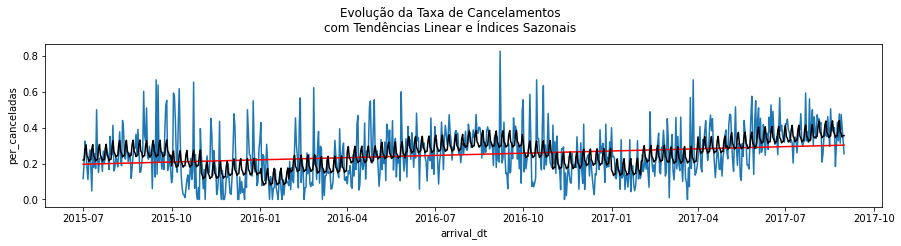

In [78]:
train_data, test_data = split_hotel_ts(tb_resort_ts_d, "2017-08-01")
dummy_names = list(ohe_fit.get_feature_names_out())

var_names = ["t_dias"] + dummy_names

season_trend_fit = lm.LinearRegression()
season_trend_fit.fit(train_data[var_names], train_data["per_canceladas"])

tb_resort_ts_d["pred_trend_season"] = season_trend_fit.predict(
    tb_resort_ts_d[var_names]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais')

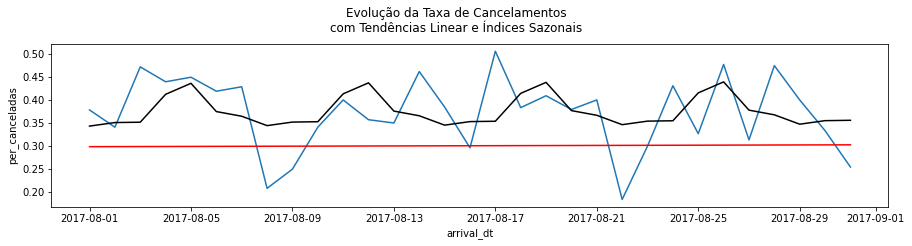

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d['arrival_dt'] >= "2017-08-01"], x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d['arrival_dt'] >= "2017-08-01"], x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d['arrival_dt'] >= "2017-08-01"], x="arrival_dt", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)

In [80]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_season"] = season_trend_fit.predict(test_data[var_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_season"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend + Season: {round(rmse_cycle, 2)}")


Trend Lin.: 0.11
Trend + Season: 0.07


# Criando nosso modelo final

In [81]:
final_list = spl_names + dummy_names + ["t_dias"]
X_train = train_data[final_list]
X_test = test_data[final_list]
y_train = train_data["per_canceladas"]
y_test = test_data["per_canceladas"]

scaler = StandardScaler()
scaler.fit(X_train)

cat_fit = cat.CatBoostRegressor(iterations=20000, depth=9, od_type="Iter", od_wait=1500, verbose = False)
cat_fit.fit(
    scaler.transform(X_train), y_train, eval_set=(scaler.transform(X_test), y_test)
)

Trend Lin.: 0.11
Trend Spline.: 0.08
Trend+Sazonal: 0.07
Trend+Spline+Seazonal: 0.08


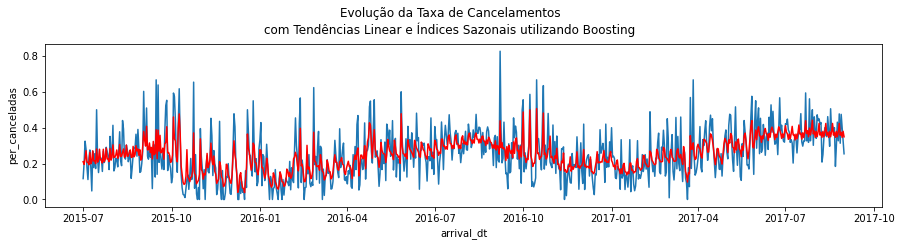

In [82]:
tb_resort_ts_d["pred_boosting"] = cat_fit.predict(
    scaler.transform(tb_resort_ts_d[final_list])
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_boosting", color="red")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
);

pred_boosting = cat_fit.predict(
    scaler.transform(X_test[final_list])
)
rmse_cat = np.sqrt(
    mean_squared_error(y_test, pred_boosting)
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")
print(f'Trend+Sazonal: {round(rmse_cycle, 2)}')
print(f"Trend+Spline+Seazonal: {round(rmse_cat, 2)}")


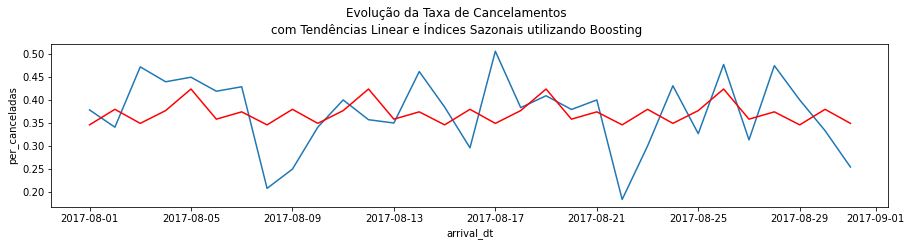

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d['arrival_dt'] >= "2017-08-01"], x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d[tb_resort_ts_d['arrival_dt'] >= "2017-08-01"], x="arrival_dt", y="pred_boosting", color="red")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
);

In [95]:
tb_resort_ts_d.columns

Index(['arrival_dt', 'num_reservas', 'num_canceladas', 'per_canceladas',
       't_dias', 'pred_trend_linear', 'S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6',
       'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16',
       'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25',
       'pred_spline', 'mes', 'dia_semana', 'mes_10', 'mes_11', 'mes_12',
       'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9',
       'dia_semana_1', 'dia_semana_2', 'dia_semana_3', 'dia_semana_4',
       'dia_semana_5', 'dia_semana_6', 'pred_trend_season', 'pred_boosting'],
      dtype='object')

<AxesSubplot:xlabel='arrival_dt', ylabel='ruido'>

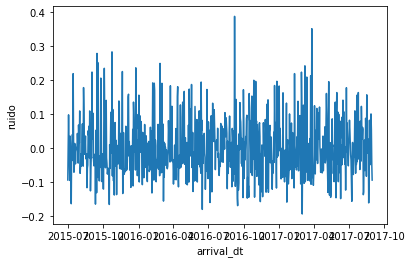

In [96]:
tb_resort_ts_d['ruido'] = tb_resort_ts_d['per_canceladas'] - tb_resort_ts_d['pred_boosting']
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="ruido")

<AxesSubplot:xlabel='ruido', ylabel='Count'>

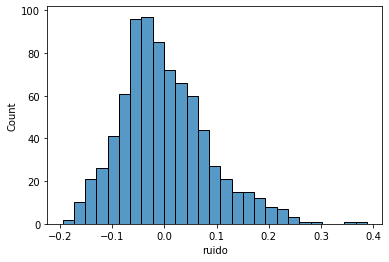

In [97]:
sns.histplot(data=tb_resort_ts_d, x="ruido")

In [99]:
tb_resort_ts_d['ano'] = tb_resort_ts_d['arrival_dt'].dt.year

In [101]:
tb_mensal = tb_resort_ts_d.groupby(['ano', 'mes'])[['per_canceladas', 'pred_boosting']].mean().reset_index()

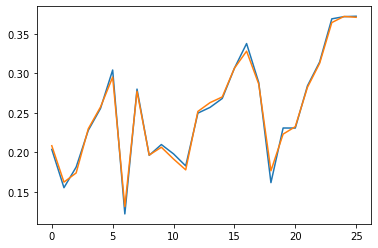

In [103]:
plt.plot(tb_mensal['per_canceladas'])
plt.plot(tb_mensal['pred_boosting'])

In [104]:
tb_mensal

,ano,mes,per_canceladas,pred_boosting
0,2015,10,0.203602,0.208248
1,2015,11,0.155055,0.162088
2,2015,12,0.181155,0.173770
3,2015,7,0.227889,0.229877
4,2015,8,0.255512,0.257322
5,2015,9,0.304318,0.295327
6,2016,1,0.121791,0.130998
7,2016,10,0.280096,0.277280
8,2016,11,0.196109,0.196427
9,2016,12,0.209782,0.206335


# Processos Auto-regressivos

## Autocorrelação e Autocorrelação Parcial

Text(0.5, 1.05, 'Evolução do Número de Reservas')

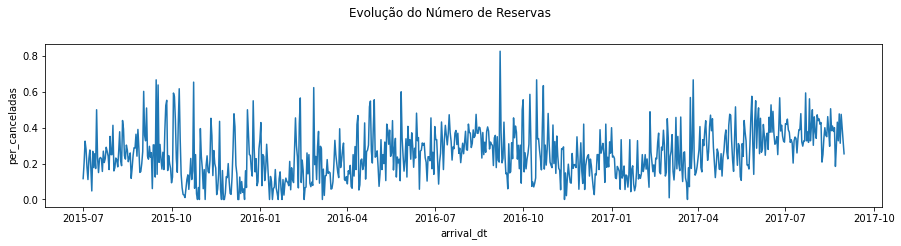

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
fig.suptitle(
    f"Evolução do Número de Reservas",
    y=1.05,
)


O método `.shift()` retorna uma série *atrasada* (ou *adiantada*) em relação a série original:

In [114]:
tb_resort_ts_d["per_canceladas_lag"] = tb_resort_ts_d["per_canceladas"].shift(1)
tb_resort_ts_d[["arrival_dt", "per_canceladas",  "per_canceladas_lag"]]

,arrival_dt,per_canceladas,per_canceladas_lag
0,2015-07-01,0.116279,NaN
1,2015-07-02,0.204545,0.116279
2,2015-07-03,0.325000,0.204545
3,2015-07-04,0.280000,0.325000
4,2015-07-05,0.177778,0.280000
...,...,...,...
788,2017-08-27,0.313433,0.476923
789,2017-08-28,0.474359,0.313433
790,2017-08-29,0.400000,0.474359
791,2017-08-30,0.333333,0.400000


In [115]:
tb_resort_ts_d["per_canceladas_lag"] = tb_resort_ts_d["per_canceladas"].shift(1)
tb_resort_ts_d[["per_canceladas", "per_canceladas_lag"]].head()


,per_canceladas,per_canceladas_lag
0,0.116279,NaN
1,0.204545,0.116279
2,0.325000,0.204545
3,0.280000,0.325000
4,0.177778,0.280000


Com esta nova coluna (`per_canceladas_lag`) podemos **visualizar** a auto-correlação (no horizonte de 1 dia) da série `per_canceladas`: a auto-correlação é a correlação de uma série temporal com seu **passado**!

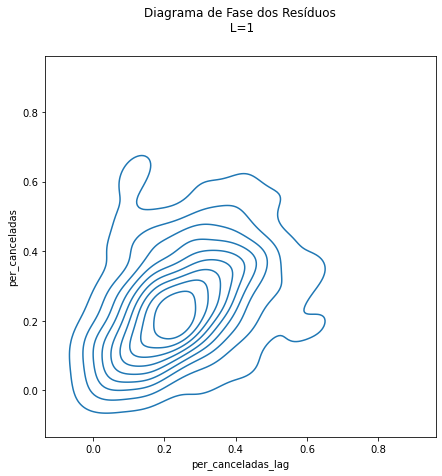

In [119]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
sns.kdeplot(
    data=tb_resort_ts_d,
    x="per_canceladas_lag",
    y="per_canceladas",
)
ax.set_title(f"Diagrama de Fase dos Resíduos\n L=1", y=1.05);


O diagrama de fase nos permite visualizar de forma simples a correlação para alguns (no caso acima um) período de lag - mas podemos ter autocorrelação em diversos atrasos (especialmente se nossa série tem sazonalidade).

Temos duas ferramentas disponíveis para entender a estrutura de auto-correlação de uma série temporal: a ACF e a PACF.

C_hat = O * b


In [121]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

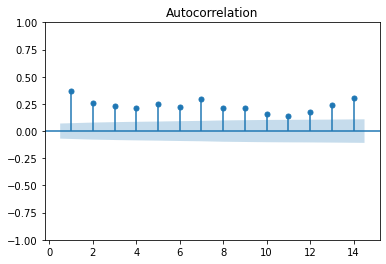

In [122]:
plot_acf(tb_resort_ts_d["per_canceladas"], lags = range(1, 15));

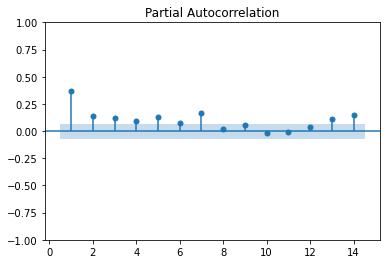

In [123]:
plot_pacf(tb_resort_ts_d["per_canceladas"], lags = range(1, 15), method = 'ywm');

## Os métodos Shift e Diff

Uma forma de tratar a auto-correlação é utilizar o histórico da propria variável modelada como variável de entrada. Podemos fazer isso neutralizando essa autocorrelação através da diferenças (Hoje - Ontem), ou então adicionar a variável *Ontem* ao modelo. **Devemos tomar cuidado pois isso muda o horizonte preditivo de nosso modelo!!**

In [124]:
from statsmodels.tsa.seasonal import STL

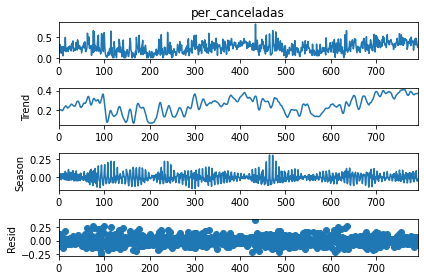

In [125]:
stl_fit = STL(tb_resort_ts_d['per_canceladas'], period = 7).fit()
stl_fit.plot()
plt.show()

## Modelos **S**(easonal)**A**(uto)**R**(egressive)**I**(ntegrated)**M**(oving)**A**(average)

Os modelos ARIMA são modelos lineares que incorporam as idéias apresentadas acima em um framework único de modelagem.

In [127]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [128]:
arima_model = SARIMAX(train_data['per_canceladas'], order = (1,0,1), seasonal_order = (1, 0, 0, 7))
arima_fit = arima_model.fit()
arima_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.66431D-01    |proj g|=  3.16803D+00

At iterate    5    f= -4.04759D-01    |proj g|=  1.90655D-01

At iterate   10    f= -5.43139D-01    |proj g|=  2.31222D+00

At iterate   15    f= -6.03457D-01    |proj g|=  1.15916D+00

At iterate   20    f= -6.49281D-01    |proj g|=  1.02164D-02


 This problem is unconstrained.



At iterate   25    f= -6.62376D-01    |proj g|=  9.18190D-02

At iterate   30    f= -6.73057D-01    |proj g|=  7.29588D-02

At iterate   35    f= -6.74502D-01    |proj g|=  7.26120D-03

At iterate   40    f= -6.74567D-01    |proj g|=  7.78721D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     55      1     0     0   1.706D-07  -6.746D-01
  F = -0.67456694209878365     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     per_canceladas   No. Observations:                  762
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 7)   Log Likelihood                 514.020
Date:                            Thu, 20 Oct 2022   AIC                          -1020.040
Time:                                    22:26:59   BIC                          -1001.496
Sample:                                         0   HQIC                         -1012.900
                                            - 762                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.001    893.539      0.000       0.997       1.002
ma.L1         -0.9249      0.014    -67.048      0.000      -0.952      -0.898
ar.S.L7        0.0783      0.034      2.312      0.021       0.012       0.145
sigma2         0.0151      0.001     23.868      0.000       0.014       0.016
===================================================================================
Ljung-Box (L1) (Q):                  18.88   Jarque-Bera (JB):               161.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

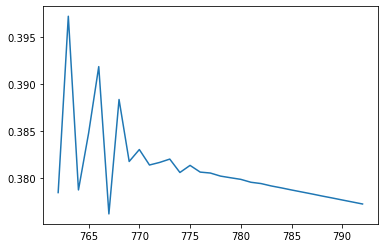

In [140]:
plt.plot(arima_fit.forecast(31, alpha = 0.95))

In [135]:
print(
    f'Erro RMSE Modelo SARIMA: {round(np.sqrt(mean_squared_error(y_test, arima_fit.forecast(31))), 2)}'
    )

Erro RMSE Modelo SARIMA: 0.08


# Apêndice

### Variáveis Sazonais Contínuas

In [141]:
tb_resort_ts_b["s_semana"] = np.sin(tb_resort_ts_b["t_dias"] / (7 / np.pi))
tb_resort_ts_b["c_semana"] = np.cos(tb_resort_ts_b["t_dias"] / (7 / np.pi))

tb_resort_ts_b["s_mes"] = np.sin(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))
tb_resort_ts_b["c_mes"] = np.cos(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))

tb_resort_ts_b["s_ano"] = np.sin(tb_resort_ts_b["t_dias"] / (365 / np.pi))
tb_resort_ts_b["c_ano"] = np.cos(tb_resort_ts_b["t_dias"] / (365 / np.pi))


Text(0.5, 0.95, 'Variáveis Contínuas Ciclicas')

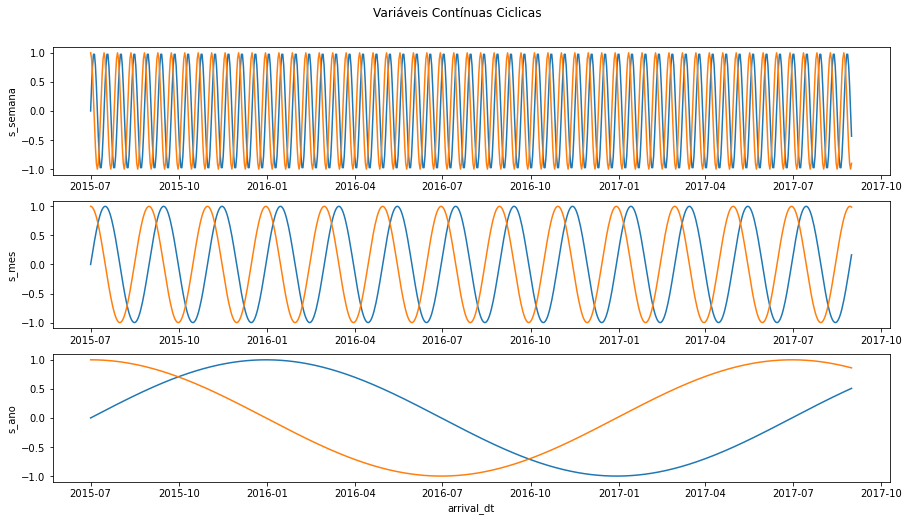

In [142]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_semana", ax=ax[0])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_semana", ax=ax[0])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_mes", ax=ax[1])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_mes", ax=ax[1])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_ano", ax=ax[2])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_ano", ax=ax[2])

ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Variáveis Contínuas Ciclicas", y=0.95)


In [143]:
c_names = ["c_semana", "s_semana", "c_mes", "s_mes", "c_ano", "s_ano"]
spl_cycle = spl_names + c_names
train_data, test_data = split_hotel_ts(tb_resort_ts_b)
spl_cycle_fit = lm.Ridge()
spl_cycle_fit.fit(train_data[spl_cycle], train_data["per_canceladas"])
tb_resort_ts_b["pred_cycle_poly"] = spl_cycle_fit.predict(tb_resort_ts_b[spl_cycle])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_cycle_poly", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


TypeError: split_hotel_ts() missing 1 required positional argument: 'break_date'

In [144]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
test_data["pred_trend_cycle"] = spl_cycle_fit.predict(test_data[spl_cycle])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spline = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_cycle"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_spline, 2)}")
print(f"Trend + Cycle: {round(rmse_cycle, 2)}")


NameError: name 'spl_cycle_fit' is not defined

## Fazendo previsões

In [ ]:
tb_resort_ts_b = tb_resort_ts.copy()
tb_resort_ts_b["mes"] = tb_resort_ts_b["arrival_dt"].dt.month.astype(str)
tb_resort_ts_b["dia_semana"] = tb_resort_ts_b["arrival_dt"].dt.weekday.astype(str)

ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])
dummy_names = list(ohe_fit.get_feature_names_out())
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=dummy_names,
        ),
    ],
    axis=1,
)

spl_trans = SplineTransformer(n_knots=24, extrapolation="constant")
spl_trans.fit(tb_resort_ts_b[["t_dias"]])
spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            spl_trans.transform(tb_resort_ts_b[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)

final_list = spl_names + dummy_names + ["t_dias"]
X = tb_resort_ts_b[final_list]
y = tb_resort_ts_b['num_reservas']
scaler = StandardScaler()
scaler.fit(X)
cat_fit = cat.CatBoostRegressor(iterations=1708, depth=9)
cat_fit.fit(scaler.transform(X), y)


In [ ]:
X_pred = range(int(max(X['t_dias'])), int(max(X['t_dias'])) + 31)
min_date = min(tb_resort_ts_b['arrival_dt'])
tb_pred = pd.DataFrame({'t_dias' : X_pred})
tb_pred['arrival_dt'] = pd.to_timedelta(tb_pred['t_dias'], 'd') + min_date

In [ ]:
tb_pred

In [ ]:
X_pred = range(int(max(X['t_dias'])), int(max(X['t_dias'])) + 31)
min_date = min(tb_resort_ts_b['arrival_dt'])
tb_pred = pd.DataFrame({'t_dias' : X_pred})
tb_pred['arrival_dt'] = pd.to_timedelta(tb_pred['t_dias'], 'd') + min_date
tb_pred["mes"] = tb_pred["arrival_dt"].dt.month.astype(str)
tb_pred["dia_semana"] = tb_pred["arrival_dt"].dt.weekday.astype(str)

tb_pred = pd.concat(
    [
        tb_pred,
        pd.DataFrame(
            ohe_fit.transform(tb_pred[["mes", "dia_semana"]]),
            columns=dummy_names,
        ),
    ],
    axis=1,
)

tb_pred = pd.concat(
    [
        tb_pred,
        pd.DataFrame(
            spl_trans.transform(tb_pred[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)

In [ ]:
tb_pred

In [ ]:
tb_pred['pred'] = cat_fit.predict(scaler.transform(tb_pred[final_list]))

In [ ]:
tb_pred['lim_inf_cancelamento'] = tb_pred['pred'] - 0.076
tb_pred['lim_sup_cancelamento'] = tb_pred['pred'] + 0.076

In [ ]:
tb_pred[['arrival_dt', 'pred', 'lim_inf_cancelamento', 'lim_sup_cancelamento']]